# SHAP

## Load DATA & train SVM

In [1]:
import pandas as pd
import os
import glob
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
# import umap
from sklearn.neighbors import KDTree
from tqdm import tqdm
import shap

### Load Raw Data

In [2]:
random_seed = 10

def load_all_partitions(directory):
    all_files = glob.glob(os.path.join(directory, '*.csv'))
    df_list = [pd.read_csv(file) for file in all_files]
    return pd.concat(df_list, ignore_index=True)

x_raw = load_all_partitions('data/AF-Raw-Data/AF Data/all_raw_data_csv')

# Remove rows that are duplicates or have values > 1800
n_before = x_raw.shape[0]
x_raw = x_raw.drop_duplicates()
x_raw = x_raw[(x_raw.T < 1800).all()]
print(f"Removed {n_before - x_raw.shape[0]} rows with values > 1800 or are duplicate")

# Balance the dataset, by taking the same number of samples from each class
class_1 = x_raw[x_raw['Class_Label'] == 1]
class_0 = x_raw[x_raw['Class_Label'] == 0].sample(len(class_1), random_state=random_seed)
x_raw = pd.concat([class_1, class_0])
print(f"Balanced dataset: {x_raw.shape[0]} samples in total")

x_raw.reset_index(drop=True, inplace=True)
x_raw['Sample_id'] = x_raw.index

# Split the class label from the features and split the data into train and test
y_raw = x_raw[['Class_Label', 'Sample_id']]
x_raw = x_raw.drop(columns=['Class_Label'])
x_raw_train, x_raw_test, y_train, y_test = train_test_split(x_raw, y_raw, test_size=0.2, random_state=random_seed)

Removed 136070 rows with values > 1800 or are duplicate
Balanced dataset: 109272 samples in total


### Create preprocessed data

In [3]:
# 30 bins (of 50 milliseconds) are created covering R-R intervals of 200 ms up to 1700 ms. For each
#sample the frequency of an R-R interval occurring in a certain bin was counted.

# Function to bin and count intervals for a row
def bin_row(row, bin_edges):
    intervals = row[:-1].values # Exclude the class label from binning
    bin_indices = np.digitize(intervals, bins=bin_edges, right=False)
    bin_counts = np.bincount(bin_indices, minlength=len(bin_edges)+1)[1:-1]  # Exclude counts outside defined bins
    return bin_counts

bin_edges = np.arange(200, 1751, 50) #ms
bin_column_names = [f'bin_{i + 1}' for i in range(len(bin_edges) - 1)]

def preprocess_into_bins(x_data):
    x_bins = x_data.apply(lambda row: bin_row(row, bin_edges), axis=1, result_type='expand')
    x_bins.columns = bin_column_names
    x_bins['Sample_id'] = x_data['Sample_id']
    return x_bins

x_bins_train = preprocess_into_bins(x_raw_train)
x_bins_test = preprocess_into_bins(x_raw_test)
x_bins = pd.concat([x_bins_train, x_bins_test], ignore_index=True)
x_bins = x_bins.sort_values('Sample_id')

### Train SVM on binned data

In [4]:
scaler = StandardScaler()
x_bins_train_scaled = scaler.fit_transform(x_bins_train[bin_column_names])

x_bins_test_scaled = scaler.transform(x_bins_test[bin_column_names])

svm = SVC(random_state=random_seed, kernel='rbf', probability=True)
svm.fit(x_bins_train_scaled, y_train['Class_Label'])

SVC(probability=True, random_state=10)

In [5]:
y_pred_test = svm.predict(x_bins_test_scaled)
y_pred_train = svm.predict(x_bins_train_scaled)

acc_test_svm = accuracy_score(y_test['Class_Label'], y_pred_test)
f1_test_svm = f1_score(y_test['Class_Label'], y_pred_test)

acc_train_svm = accuracy_score(y_train['Class_Label'], y_pred_train)
f1_train_svm = f1_score(y_train['Class_Label'], y_pred_train)

print(f"Test accuracy: {round(acc_test_svm, 4)}, F1: {round(f1_test_svm, 4)}")
print(f"Train accuracy: {round(acc_train_svm, 4)}, F1: {round(f1_train_svm, 4)}")

Test accuracy: 0.9513, F1: 0.9514
Train accuracy: 0.9536, F1: 0.9538


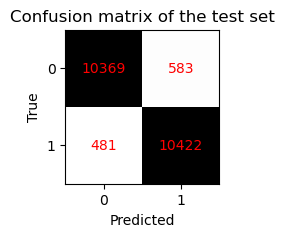

In [6]:
cm_test = confusion_matrix(y_test['Class_Label'], y_pred_test)
#visualise it nicely
plt.figure(figsize=(2, 2))
plt.imshow(cm_test, cmap='binary')
plt.grid(False)
for i in range(2):
    for j in range(2):
        plt.text(j, i, cm_test[i, j], ha='center', va='center', color='red')
plt.ylabel('True'), plt.xlabel('Predicted'), plt.xticks([0, 1], ['0', '1']), plt.yticks([0, 1], ['0', '1'])
plt.title('Confusion matrix of the test set')
plt.show()

## Select 10% of the data for SHAP

In [7]:
#select random 10000 of the training sample size
num_samples = int(0.1 * x_bins_train_scaled.shape[0])
# num_samples
random_indices = np.random.choice(x_bins_train_scaled.shape[0], num_samples, replace=False)

In [8]:
sub_train_data= x_bins_train_scaled[random_indices]

## Define shap explainer

In [9]:
f = lambda x: svm.predict_proba(x)[:,1]
explainer = shap.KernelExplainer(f, sub_train_data)

Using 8741 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


## SHAP for first 2 FN and TN

In [33]:
fp_index = None
fn_index = None
tp_index = None
tn_index = None

fp_found = False
fn_found = False
tp_found = False
tn_found = False

for i in range(len(y_test)):
    actual = y_test['Class_Label'].iloc[i]
    predicted = y_pred_test[i]

    # False Positive (1 predicted, but actually 0)
    if predicted == 1 and actual == 0 and not fp_found:
        fp_index = i
        fp_found = True

    # False Negative (0 predicted, but actually 1)
    elif predicted == 0 and actual == 1 and not fn_found:
        fn_index = i
        fn_found = True

    # True Positive (1 predicted, actually 1)
    elif predicted == 1 and actual == 1 and not tp_found:
        tp_index = i
        tp_found = True

    # True Negative (0 predicted, actually 0)
    elif predicted == 0 and actual == 0 and not tn_found:
        tn_index = i
        tn_found = True

    # Break loop if all cases found
    if fp_found and fn_found and tp_found and tn_found:
        break

# Print indices for verification
print("FP Index:", fp_index)
print("FN Index:", fn_index)
print("TP Index:", tp_index)
print("TN Index:", tn_index)


FP Index: 46
FN Index: 4
TP Index: 0
TN Index: 2


### FP 1

In [34]:
shap_values_fp = explainer.shap_values(x_bins_test_scaled[fp_index], nsamples=40)

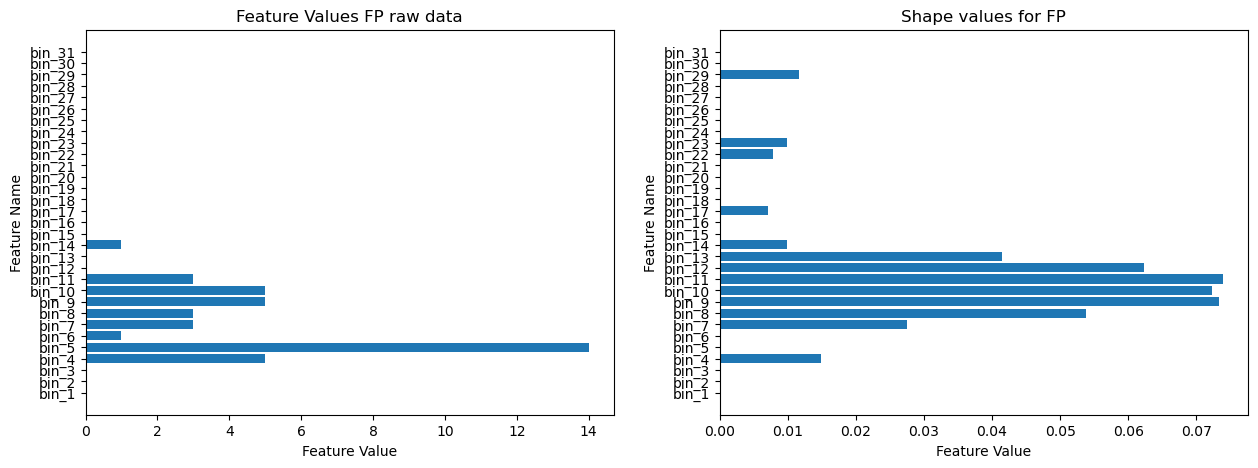

In [88]:
# create a subplot for the feature values and shap values
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

fp_test=x_bins_test.iloc[fp_index]
#select only bin columns
fp_test=fp_test[bin_column_names]
#plot the FP feature values in horizontal bar chart
axs[0].barh(bin_column_names, fp_test)
axs[0].set_xlabel('Feature Value')
axs[0].set_ylabel('Feature Name')
axs[0].set_title('Feature Values FP raw data')
#plot the FP feature values in horizontal bar chart
axs[1].barh(bin_column_names, shap_values_fp)
axs[1].set_xlabel('Feature Value')
axs[1].set_ylabel('Feature Name')
axs[1].set_title('Shape values for FP')
plt.savefig('shap_fp_sample1.png')
plt.show()

In [62]:
shap.force_plot(explainer.expected_value, shap_values_fp, fp_test, feature_names=bin_column_names)

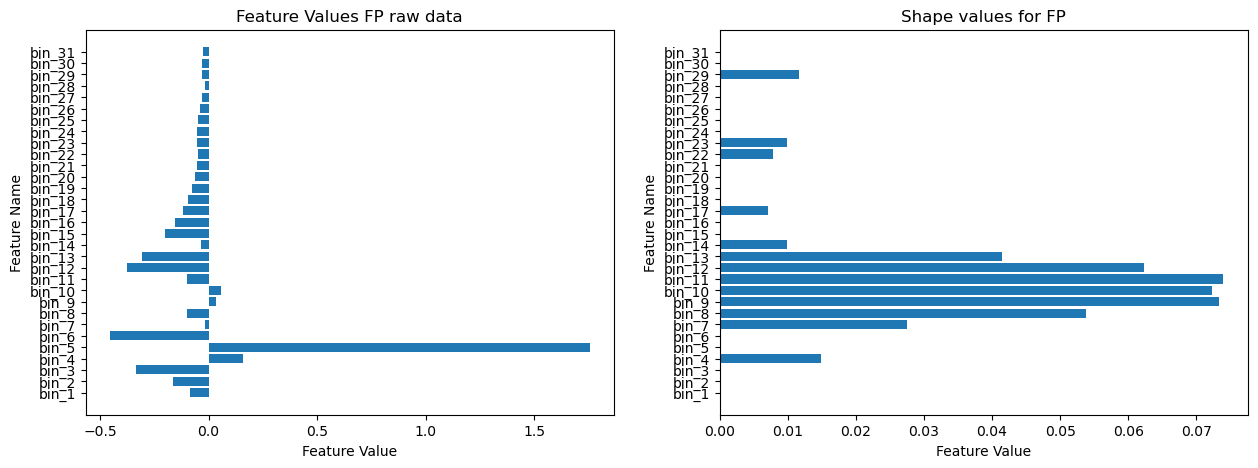

In [117]:
# create a subplot for the feature values and shap values
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
#plot the FP feature values in horizontal bar chart
axs[0].barh(bin_column_names, x_bins_test_scaled[fp_index])
axs[0].set_xlabel('Feature Value')
axs[0].set_ylabel('Feature Name')
axs[0].set_title('Feature Values FP raw data')
#plot the FP feature values in horizontal bar chart
axs[1].barh(bin_column_names, shap_values_fp)
axs[1].set_xlabel('Feature Value')
axs[1].set_ylabel('Feature Name')
axs[1].set_title('Shape values for FP')
plt.savefig('ResultsImg/shap_fp_sample1_normalized.png')
plt.show()

In [90]:
shap.force_plot(explainer.expected_value, shap_values_fp, x_bins_test_scaled[fp_index], feature_names=bin_column_names)

### TP 1

In [36]:
shap_values_tp = explainer.shap_values(x_bins_test_scaled[tp_index], nsamples=40)

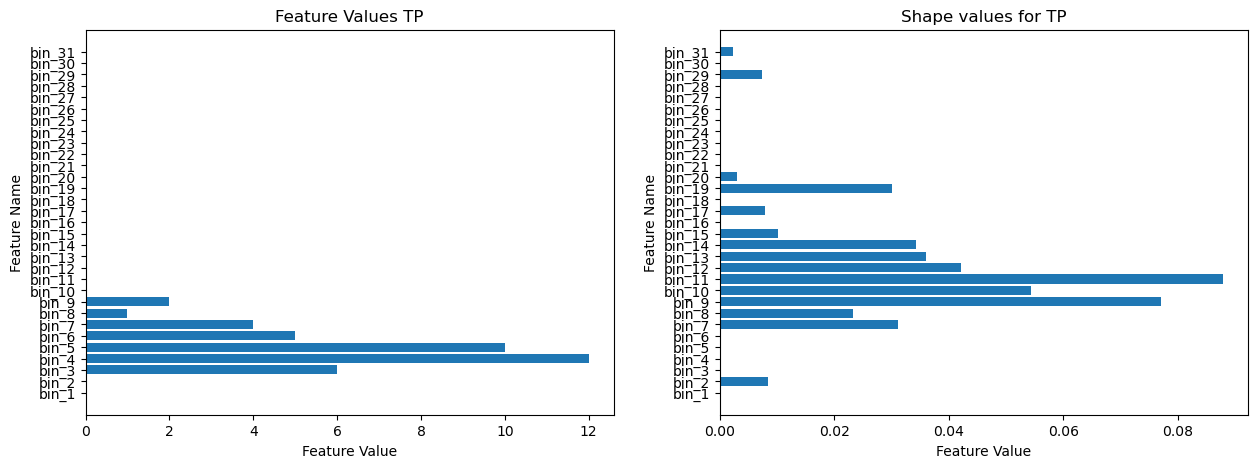

In [63]:
# create a subplot for the feature values and shap values
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

tp_test=x_bins_test.iloc[tp_index]
#select only bin columns
tp_test=tp_test[bin_column_names]

#plot the FP feature values in horizontal bar chart
axs[0].barh(bin_column_names, tp_test)
axs[0].set_xlabel('Feature Value')
axs[0].set_ylabel('Feature Name')
axs[0].set_title('Feature Values TP')
#plot the FP feature values in horizontal bar chart
axs[1].barh(bin_column_names, shap_values_tp)
axs[1].set_xlabel('Feature Value')
axs[1].set_ylabel('Feature Name')
axs[1].set_title('Shape values for TP')
plt.savefig('shap_tp_sample1.png')
plt.show()

In [64]:
shap.force_plot(explainer.expected_value, shap_values_tp, tp_test, feature_names=bin_column_names)

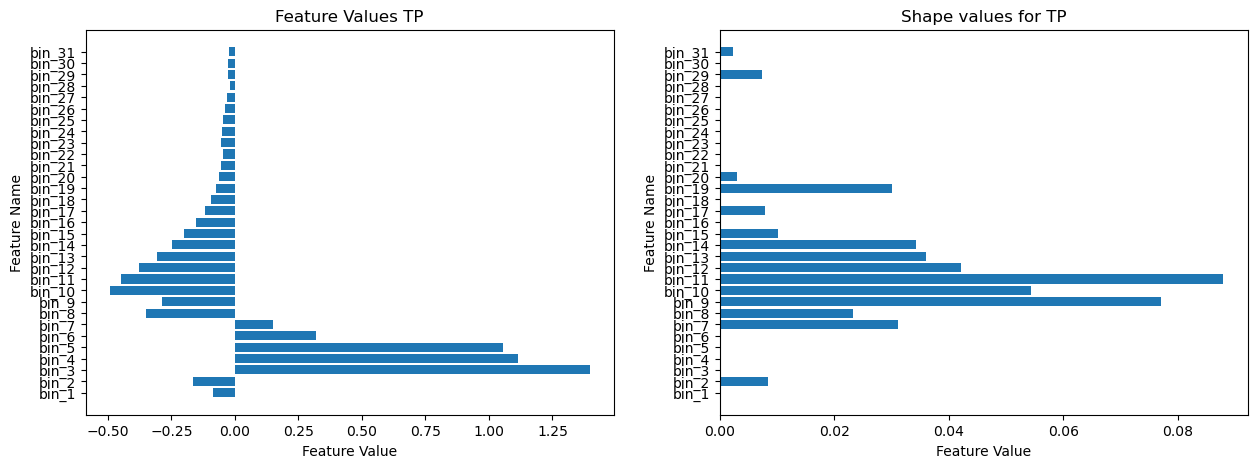

In [91]:
# create a subplot for the feature values and shap values
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

#plot the FP feature values in horizontal bar chart
axs[0].barh(bin_column_names, x_bins_test_scaled[tp_index])
axs[0].set_xlabel('Feature Value')
axs[0].set_ylabel('Feature Name')
axs[0].set_title('Feature Values TP')
#plot the FP feature values in horizontal bar chart
axs[1].barh(bin_column_names, shap_values_tp)
axs[1].set_xlabel('Feature Value')
axs[1].set_ylabel('Feature Name')
axs[1].set_title('Shape values for TP')
plt.savefig('shap_tp_sample1_normalized.png')
plt.show()

In [92]:
shap.force_plot(explainer.expected_value, shap_values_tp, x_bins_test_scaled[tp_index], feature_names=bin_column_names)

In [38]:
shap_values_fn = explainer.shap_values(x_bins_test_scaled[fn_index], nsamples=40)

/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_least_angle.py:679: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 2 iterations, alpha=1.495e-02, previous alpha=1.446e-02, with an active set of 3 regressors.
  warnings.warn(


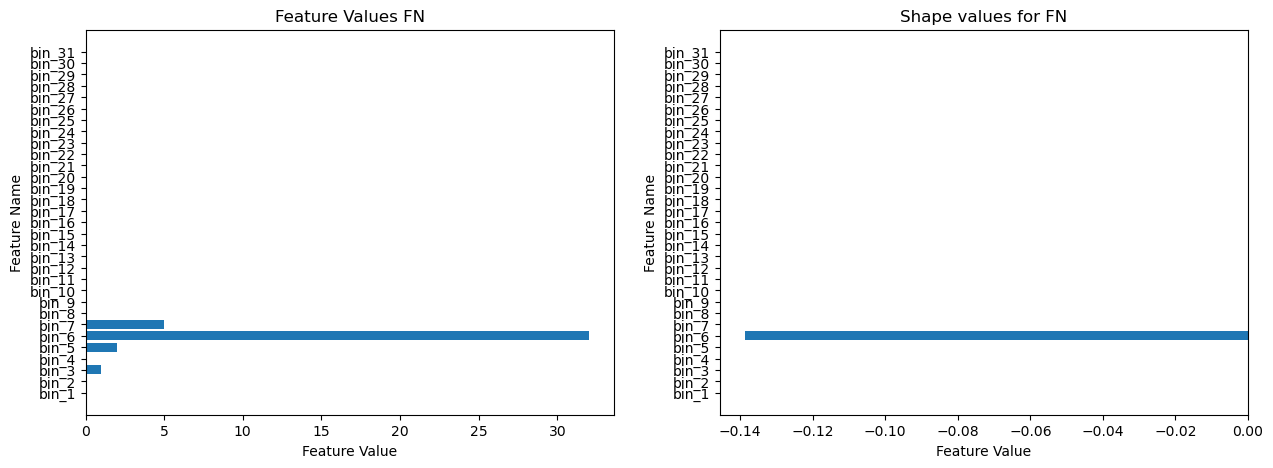

In [65]:
# create a subplot for the feature values and shap values
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
fn_test=x_bins_test.iloc[fn_index]
#select only bin columns
fn_test=fn_test[bin_column_names]
#plot the FP feature values in horizontal bar chart
axs[0].barh(bin_column_names, fn_test)
axs[0].set_xlabel('Feature Value')
axs[0].set_ylabel('Feature Name')
axs[0].set_title('Feature Values FN')
#plot the FP feature values in horizontal bar chart
axs[1].barh(bin_column_names, shap_values_fn)
axs[1].set_xlabel('Feature Value')
axs[1].set_ylabel('Feature Name')
axs[1].set_title('Shape values for FN')
plt.savefig('shap_fn_sample1.png')
plt.show()

In [66]:
shap.force_plot(explainer.expected_value, shap_values_fn, fn_test, feature_names=bin_column_names)

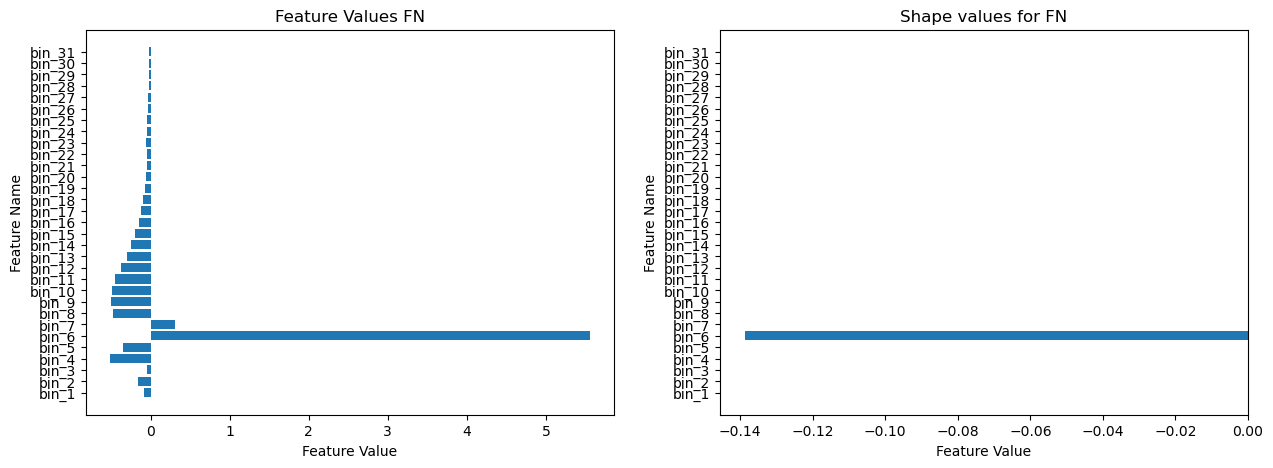

In [95]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
#plot the FP feature values in horizontal bar chart
axs[0].barh(bin_column_names, x_bins_test_scaled[fn_index])
axs[0].set_xlabel('Feature Value')
axs[0].set_ylabel('Feature Name')
axs[0].set_title('Feature Values FN')
#plot the FP feature values in horizontal bar chart
axs[1].barh(bin_column_names, shap_values_fn)
axs[1].set_xlabel('Feature Value')
axs[1].set_ylabel('Feature Name')
axs[1].set_title('Shape values for FN')
plt.savefig('shap_fn_sample1_normalized.png')
plt.show()

In [96]:
shap.force_plot(explainer.expected_value, shap_values_fn, x_bins_test_scaled[fn_index], feature_names=bin_column_names)

In [40]:
shap_values_tn = explainer.shap_values(x_bins_test_scaled[tn_index], nsamples=40)

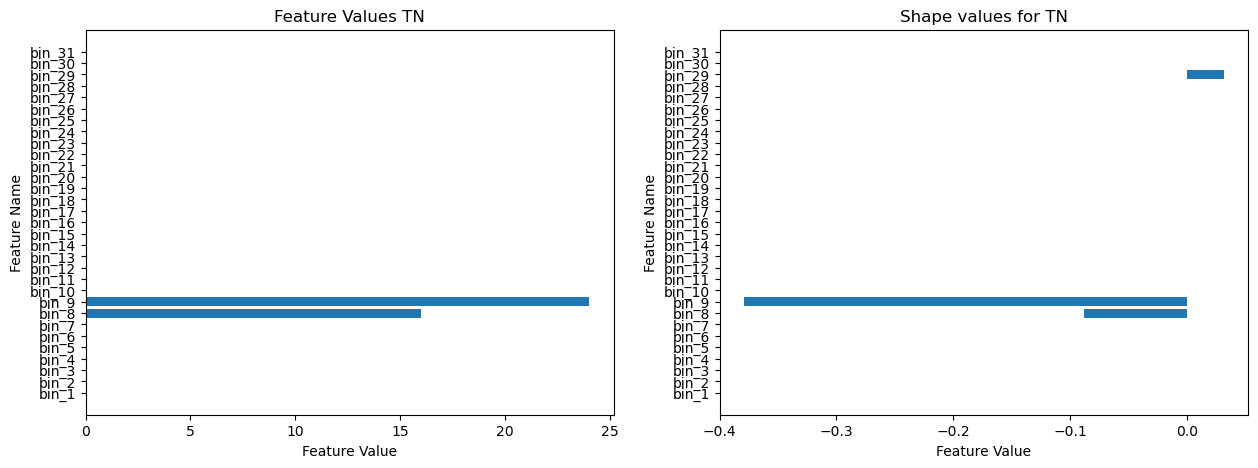

In [67]:
# create a subplot for the feature values and shap values
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
tn_test=x_bins_test.iloc[tn_index]
#select only bin columns
tn_test=tn_test[bin_column_names]
#plot the FP feature values in horizontal bar chart
axs[0].barh(bin_column_names, tn_test)
axs[0].set_xlabel('Feature Value')
axs[0].set_ylabel('Feature Name')
axs[0].set_title('Feature Values TN')
#plot the FP feature values in horizontal bar chart
axs[1].barh(bin_column_names, shap_values_tn)
axs[1].set_xlabel('Feature Value')
axs[1].set_ylabel('Feature Name')
axs[1].set_title('Shape values for TN')
plt.savefig('shap_tn_sample1.png')
plt.show()

In [60]:
shap.force_plot(explainer.expected_value, shap_values_tn, tn_test, feature_names=bin_column_names)

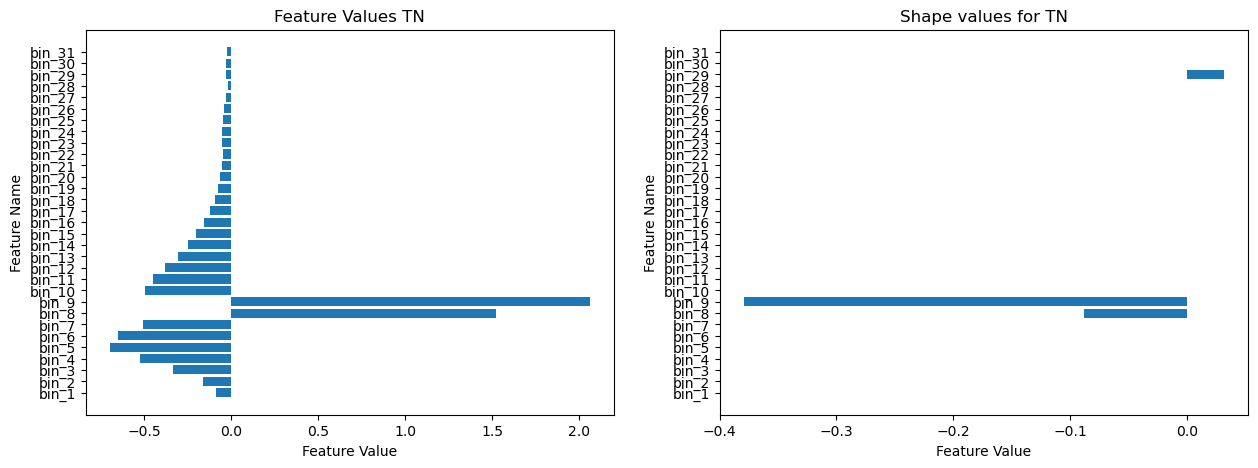

In [98]:
# create a subplot for the feature values and shap values
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
#plot the FP feature values in horizontal bar chart
axs[0].barh(bin_column_names, x_bins_test_scaled[tn_index])
axs[0].set_xlabel('Feature Value')
axs[0].set_ylabel('Feature Name')
axs[0].set_title('Feature Values TN')
#plot the FP feature values in horizontal bar chart
axs[1].barh(bin_column_names, shap_values_tn)
axs[1].set_xlabel('Feature Value')
axs[1].set_ylabel('Feature Name')
axs[1].set_title('Shape values for TN')
plt.savefig('shap_tn_sample1_normalized.png')
plt.show()

In [99]:
shap.force_plot(explainer.expected_value, shap_values_tn, x_bins_test_scaled[tn_index], feature_names=bin_column_names)

## Get all FN,FP,TP and TN indices

In [42]:
fp_index_all = []
fn_index_all = []
tp_index_all = []
tn_index_all = []

fp_found = False
fn_found = False
tp_found = False
tn_found = False

for i in range(len(y_test)):
    actual = y_test['Class_Label'].iloc[i]
    predicted = y_pred_test[i]

    # False Positive (1 predicted, but actually 0)
    if predicted == 1 and actual == 0:
        fp_index_all.append(i) #= i

    # False Negative (0 predicted, but actually 1)
    elif predicted == 0 and actual == 1:
        fn_index_all.append(i) # = i

    # True Positive (1 predicted, actually 1)
    elif predicted == 1 and actual == 1:
        tp_index_all.append(i)# = i

    # True Negative (0 predicted, actually 0)
    elif predicted == 0 and actual == 0:
        tn_index_all.append(i)# = i

    # Break loop if all cases found
    # if fp_found and fn_found and tp_found and tn_found:
    #     break

# Print indices for verification
print("FP Index:", len(fp_index_all))
print("FN Index:", len(fn_index_all))
print("TP Index:", len(tp_index_all))
print("TN Index:", len(tn_index_all))


FP Index: 583
FN Index: 481
TP Index: 10422
TN Index: 10369


In [43]:
shap_values_fp2 = explainer.shap_values(x_bins_test_scaled[fp_index_all[1]], nsamples=40)

/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_least_angle.py:649: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 10 iterations, i.e. alpha=1.524e-03, with an active set of 10 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_least_angle.py:679: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 19 iterations, alpha=3.463e-04, previous alpha=3.463e-04, with an active set of 14 regressors.
  warnings.warn(


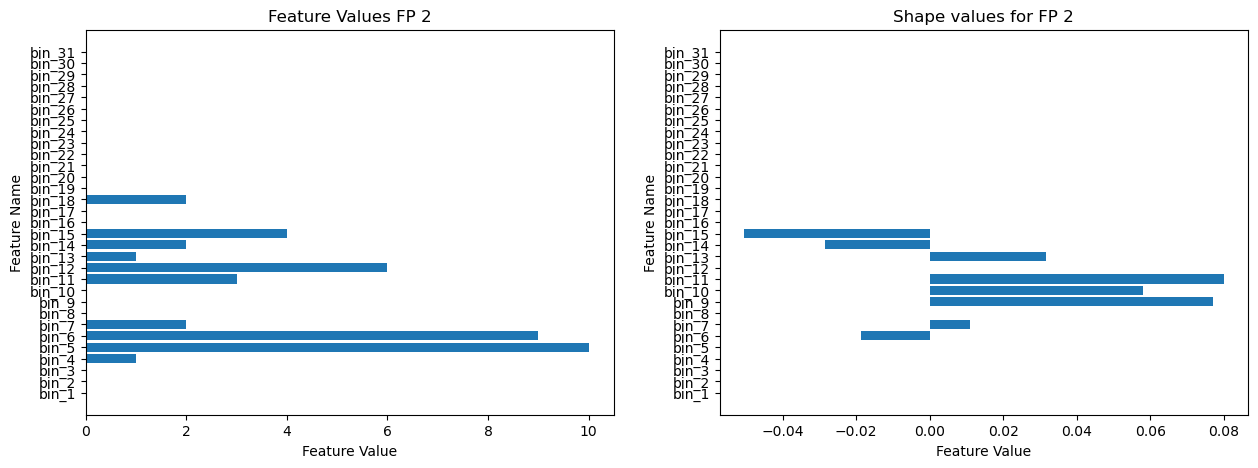

In [78]:
# create a subplot for the feature values and shap values
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
fp_test=x_bins_test.iloc[fp_index_all[1]]
#select only bin columns
fp_test=fp_test[bin_column_names]
#plot the FP feature values in horizontal bar chart
axs[0].barh(bin_column_names, fp_test)
axs[0].set_xlabel('Feature Value')
axs[0].set_ylabel('Feature Name')
axs[0].set_title('Feature Values FP 2')
#plot the FP feature values in horizontal bar chart
axs[1].barh(bin_column_names, shap_values_fp2)
axs[1].set_xlabel('Feature Value')
axs[1].set_ylabel('Feature Name')
axs[1].set_title('Shape values for FP 2')
plt.savefig('shap_fp_sample2.png')
plt.show()

In [103]:
shap.force_plot(explainer.expected_value, shap_values_fp2, fp_test, feature_names=bin_column_names)

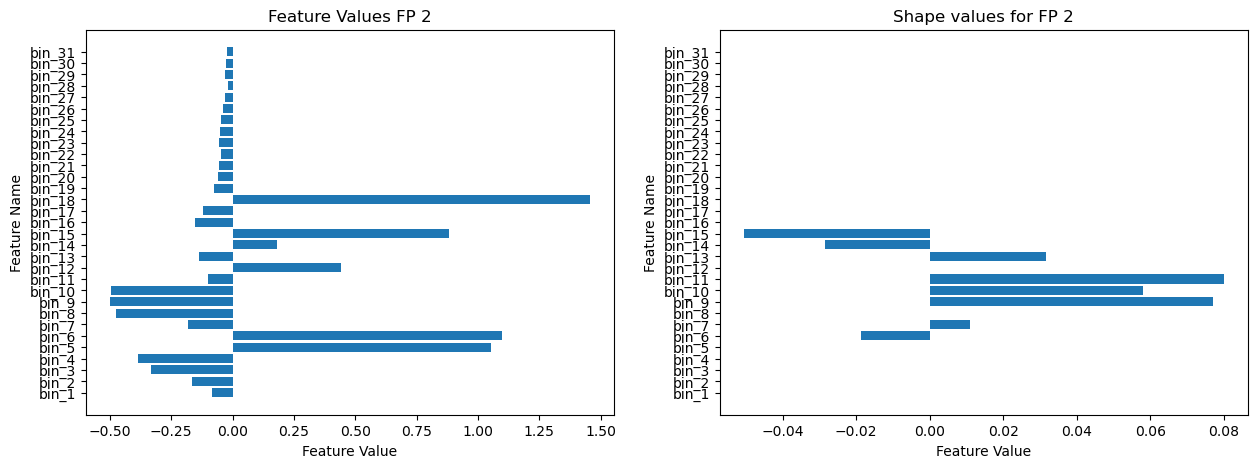

In [106]:
# create a subplot for the feature values and shap values
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
#plot the FP feature values in horizontal bar chart
axs[0].barh(bin_column_names, x_bins_test_scaled[fp_index_all[1]])
axs[0].set_xlabel('Feature Value')
axs[0].set_ylabel('Feature Name')
axs[0].set_title('Feature Values FP 2')
#plot the FP feature values in horizontal bar chart
axs[1].barh(bin_column_names, shap_values_fp2)
axs[1].set_xlabel('Feature Value')
axs[1].set_ylabel('Feature Name')
axs[1].set_title('Shape values for FP 2')
plt.savefig('shap_fp_sample2_normalized.png')
plt.show()

In [104]:
shap.force_plot(explainer.expected_value, shap_values_fp2, x_bins_test_scaled[fp_index_all[1]], feature_names=bin_column_names)

In [45]:
shap_values_tp2 = explainer.shap_values(x_bins_test_scaled[tp_index_all[1]], nsamples=40)

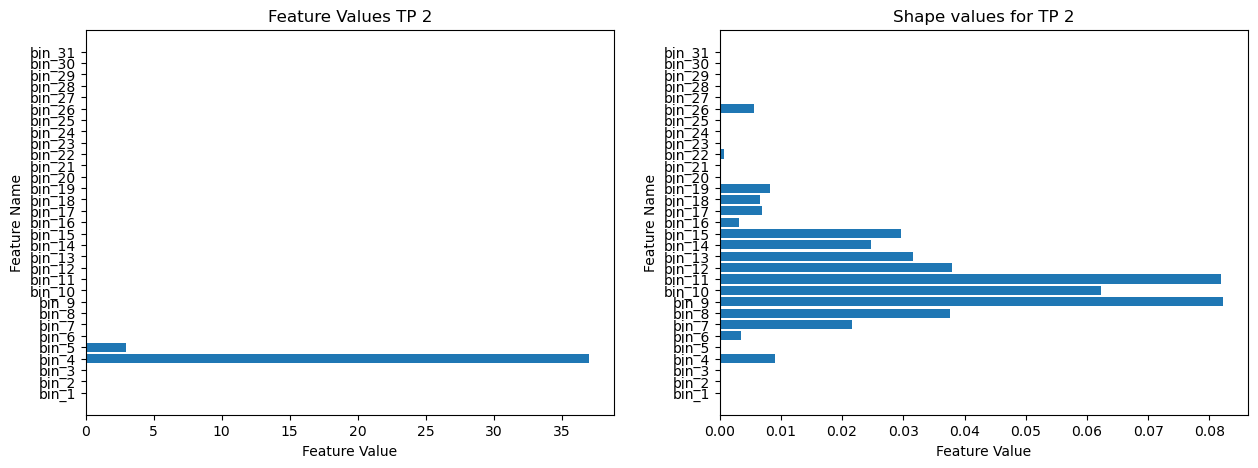

In [81]:
# create a subplot for the feature values and shap values
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
tp_test=x_bins_test.iloc[tp_index_all[1]]
#select only bin columns
tp_test=tp_test[bin_column_names]
#plot the FP feature values in horizontal bar chart
axs[0].barh(bin_column_names,tp_test)
axs[0].set_xlabel('Feature Value')
axs[0].set_ylabel('Feature Name')
axs[0].set_title('Feature Values TP 2')
#plot the FP feature values in horizontal bar chart
axs[1].barh(bin_column_names, shap_values_tp2)
axs[1].set_xlabel('Feature Value')
axs[1].set_ylabel('Feature Name')
axs[1].set_title('Shape values for TP 2')
plt.savefig('shap_tp_sample2.png')
plt.show()

In [82]:
shap.force_plot(explainer.expected_value, shap_values_tp2, tp_test, feature_names=bin_column_names)

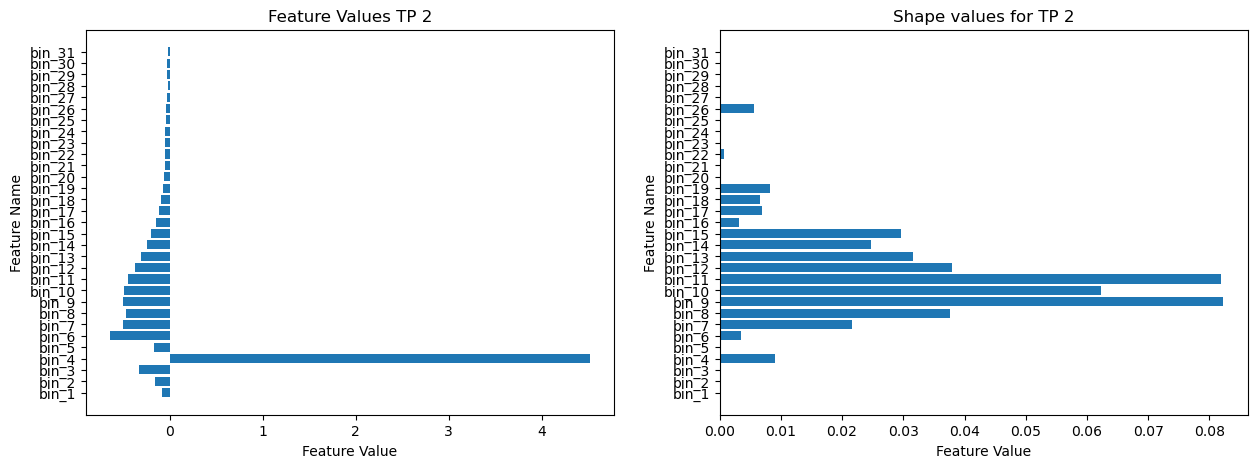

In [110]:
# create a subplot for the feature values and shap values
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
#plot the FP feature values in horizontal bar chart
axs[0].barh(bin_column_names,x_bins_test_scaled[tp_index_all[1]])
axs[0].set_xlabel('Feature Value')
axs[0].set_ylabel('Feature Name')
axs[0].set_title('Feature Values TP 2')
#plot the FP feature values in horizontal bar chart
axs[1].barh(bin_column_names, shap_values_tp2)
axs[1].set_xlabel('Feature Value')
axs[1].set_ylabel('Feature Name')
axs[1].set_title('Shape values for TP 2')
plt.savefig('shap_tp_sample2_normalized.png')
plt.show()

In [118]:
shap.force_plot(explainer.expected_value, shap_values_tp2, x_bins_test_scaled[tp_index_all[1]], feature_names=bin_column_names)

In [47]:
shap_values_fn2 = explainer.shap_values(x_bins_test_scaled[fn_index_all[1]], nsamples=40)

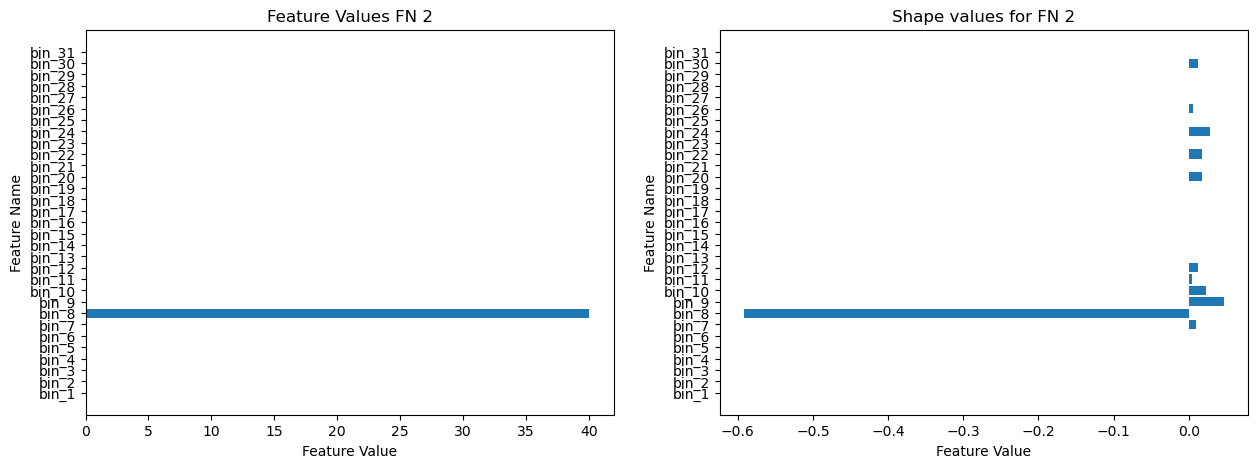

In [83]:
# create a subplot for the feature values and shap values
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
fn_test=x_bins_test.iloc[fn_index_all[1]]
#select only bin columns
fn_test=fn_test[bin_column_names]
#plot the FP feature values in horizontal bar chart
axs[0].barh(bin_column_names, fn_test)
axs[0].set_xlabel('Feature Value')
axs[0].set_ylabel('Feature Name')
axs[0].set_title('Feature Values FN 2')
#plot the FP feature values in horizontal bar chart
axs[1].barh(bin_column_names, shap_values_fn2)
axs[1].set_xlabel('Feature Value')
axs[1].set_ylabel('Feature Name')
axs[1].set_title('Shape values for FN 2')
plt.savefig('shap_fn_sample2.png')
plt.show()

In [85]:
shap.force_plot(explainer.expected_value, shap_values_fn2, fn_test, feature_names=bin_column_names)

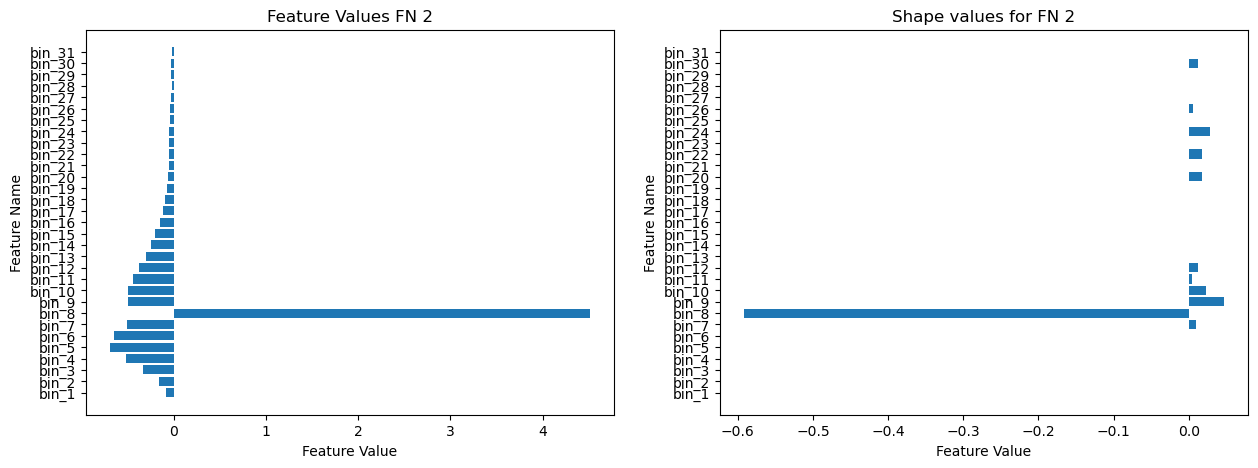

In [109]:
# create a subplot for the feature values and shap values
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

#plot the FP feature values in horizontal bar chart
axs[0].barh(bin_column_names, x_bins_test_scaled[fn_index_all[1]])
axs[0].set_xlabel('Feature Value')
axs[0].set_ylabel('Feature Name')
axs[0].set_title('Feature Values FN 2')
#plot the FP feature values in horizontal bar chart
axs[1].barh(bin_column_names, shap_values_fn2)
axs[1].set_xlabel('Feature Value')
axs[1].set_ylabel('Feature Name')
axs[1].set_title('Shape values for FN 2')
plt.savefig('shap_fn_sample2_normalized.png')
plt.show()

In [111]:
shap.force_plot(explainer.expected_value, shap_values_fn2, x_bins_test_scaled[fn_index_all[1]], feature_names=bin_column_names)

In [49]:
shap_values_tn2 = explainer.shap_values(x_bins_test_scaled[tn_index_all[1]], nsamples=40)

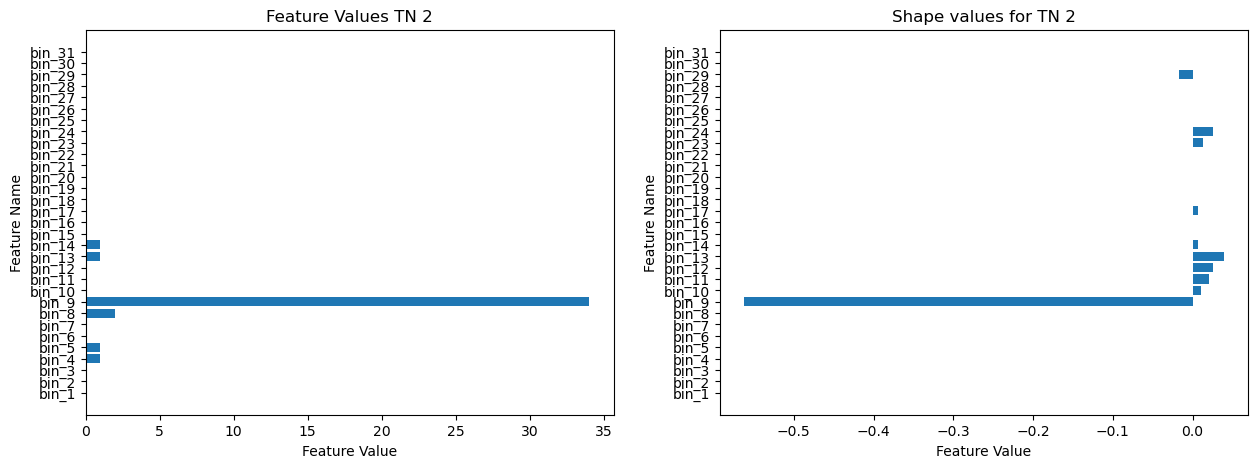

In [100]:
# create a subplot for the feature values and shap values
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
tn_test=x_bins_test.iloc[tn_index_all[1]]
#select only bin columns
tn_test=tn_test[bin_column_names]
#plot the FP feature values in horizontal bar chart
axs[0].barh(bin_column_names,tn_test)
axs[0].set_xlabel('Feature Value')
axs[0].set_ylabel('Feature Name')
axs[0].set_title('Feature Values TN 2')
#plot the FP feature values in horizontal bar chart
axs[1].barh(bin_column_names, shap_values_tn2)
axs[1].set_xlabel('Feature Value')
axs[1].set_ylabel('Feature Name')
axs[1].set_title('Shape values for TN 2')
plt.savefig('shap_tn_sample2.png')
plt.show()

In [101]:
shap.force_plot(explainer.expected_value, shap_values_tn2, tn_test, feature_names=bin_column_names)

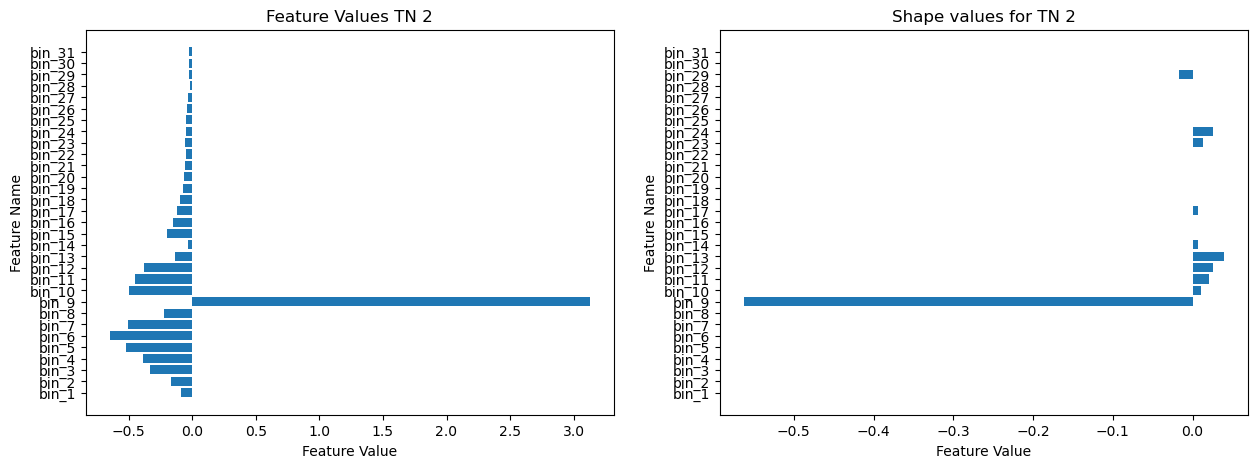

In [102]:
# create a subplot for the feature values and shap values
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

#plot the FP feature values in horizontal bar chart
axs[0].barh(bin_column_names, x_bins_test_scaled[tn_index_all[1]])
axs[0].set_xlabel('Feature Value')
axs[0].set_ylabel('Feature Name')
axs[0].set_title('Feature Values TN 2')
#plot the FP feature values in horizontal bar chart
axs[1].barh(bin_column_names, shap_values_tn2)
axs[1].set_xlabel('Feature Value')
axs[1].set_ylabel('Feature Name')
axs[1].set_title('Shape values for TN 2')
plt.savefig('shap_tn_sample2_normalized.png')
plt.show()

In [76]:
shap.force_plot(explainer.expected_value, shap_values_tn2, x_bins_test_scaled[tn_index_all[1]], feature_names=bin_column_names)

## Sample 3

In [112]:
shap_values_fp3 = explainer.shap_values(x_bins_test_scaled[fp_index_all[2]], nsamples=40)

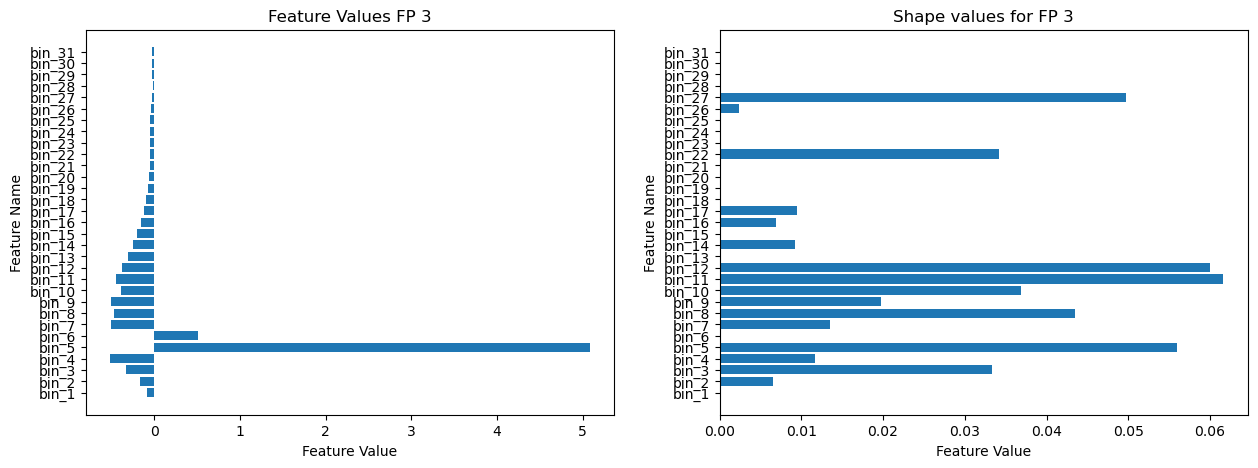

In [114]:
# create a subplot for the feature values and shap values
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

#plot the FP feature values in horizontal bar chart
axs[0].barh(bin_column_names, x_bins_test_scaled[fp_index_all[2]])
axs[0].set_xlabel('Feature Value')
axs[0].set_ylabel('Feature Name')
axs[0].set_title('Feature Values FP 3')
#plot the FP feature values in horizontal bar chart
axs[1].barh(bin_column_names, shap_values_fp3)
axs[1].set_xlabel('Feature Value')
axs[1].set_ylabel('Feature Name')
axs[1].set_title('Shape values for FP 3')
plt.savefig('shap_fp_sample2.png')
plt.show()

In [115]:
shap.force_plot(explainer.expected_value, shap_values_fp3, x_bins_test_scaled[fp_index_all[2]], feature_names=bin_column_names)

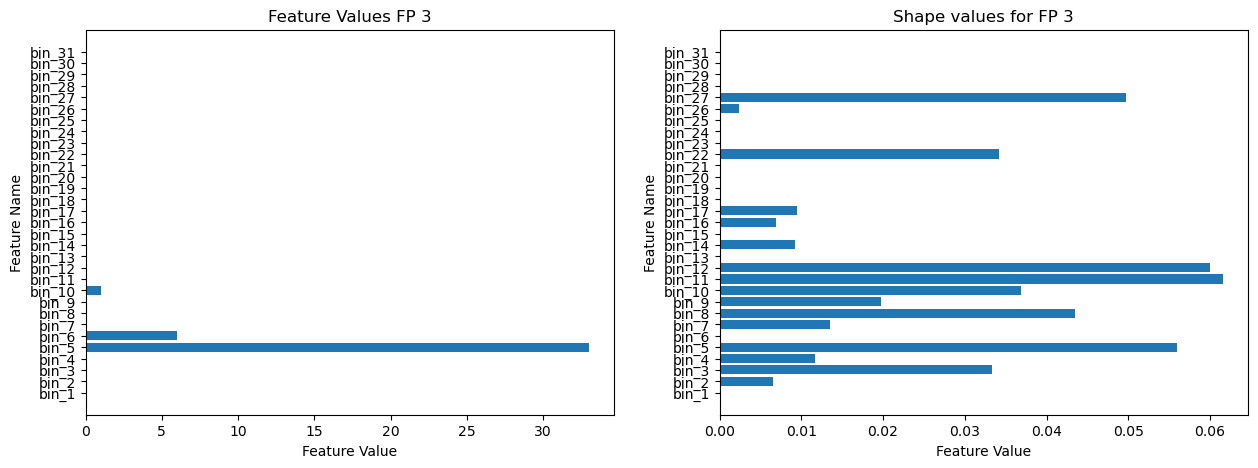

In [116]:
# create a subplot for the feature values and shap values
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
fp_test=x_bins_test.iloc[fp_index_all[2]]
#select only bin columns
fp_test=fp_test[bin_column_names]
#plot the FP feature values in horizontal bar chart
axs[0].barh(bin_column_names, fp_test)
axs[0].set_xlabel('Feature Value')
axs[0].set_ylabel('Feature Name')
axs[0].set_title('Feature Values FP 3')
#plot the FP feature values in horizontal bar chart
axs[1].barh(bin_column_names, shap_values_fp3)
axs[1].set_xlabel('Feature Value')
axs[1].set_ylabel('Feature Name')
axs[1].set_title('Shape values for FP 3')
plt.savefig('shap_fp_sample2.png')
plt.show()

In [113]:
shap.force_plot(explainer.expected_value, shap_values_fp3,fp_test, feature_names=bin_column_names)

## UMAP Implementation using Gijs's code:

In [10]:
# To the test set, add the predictions of the model
x_bins_test['Prediction'] = y_pred_test
x_bins_train['Prediction'] = y_pred_train
x_bins_test['Class_Label'] = y_test['Class_Label']
x_bins_train['Class_Label'] = y_train['Class_Label']

def add_col_cm_label(x_df):
    # Add a column indicating TP, TN, FP, FN, name the column 'CM_Label'
    x_df['CM_Label'] = ''
    x_df.loc[(x_df['Prediction'] == 1) & (x_df['Class_Label'] == 1), 'CM_Label'] = 'TP'
    x_df.loc[(x_df['Prediction'] == 0) & (x_df['Class_Label'] == 0), 'CM_Label'] = 'TN'
    x_df.loc[(x_df['Prediction'] == 1) & (x_df['Class_Label'] == 0), 'CM_Label'] = 'FP'
    x_df.loc[(x_df['Prediction'] == 0) & (x_df['Class_Label'] == 1), 'CM_Label'] = 'FN'
    return x_df

x_bins_test = add_col_cm_label(x_bins_test)
x_bins_train = add_col_cm_label(x_bins_train)

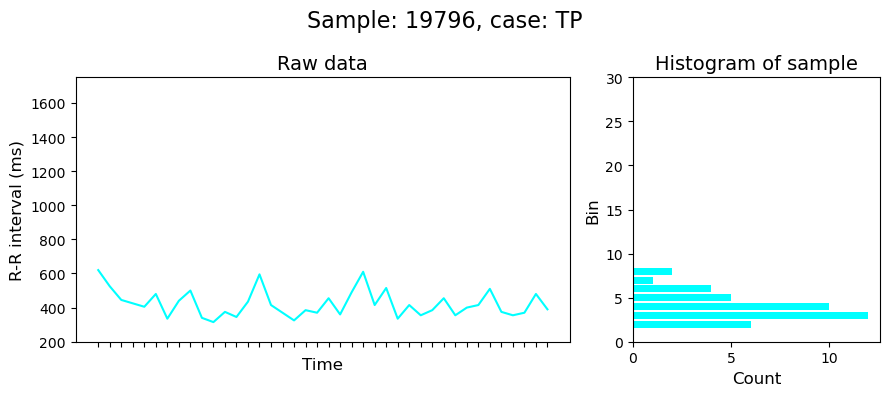

In [11]:
# Plot a sample

def plot_sample(sample_id, color_case ='cyan'):
    sample_raw = x_raw_test[x_raw_test['Sample_id'] == sample_id]
    sample_bin = x_bins_test[x_bins_test['Sample_id'] == sample_id]
    sample_pred = sample_bin['Prediction'].values[0]
    sample_gt = sample_bin['Class_Label'].values[0]
    sample_cm_label = sample_bin['CM_Label'].values[0]

    fig, axs = plt.subplots(1, 2, figsize=(9, 4), gridspec_kw={'width_ratios': [2, 1]})
    fig.suptitle(f'Sample: {sample_id}, case: {sample_cm_label}', fontsize=16)

    # Plot the raw data
    axs[0].plot(sample_raw.iloc[0][:-1], color=color_case)
    axs[0].set_title(f"Raw data", fontsize=14)
    axs[0].set_xlabel("Time", fontsize=12)
    axs[0].set_ylabel("R-R interval (ms)", fontsize=12)
    axs[0].set_xticklabels([])
    axs[0].set_ylim(200, 1750)

    axs[1].barh(range(0, 31), sample_bin[bin_column_names].values[0], color=color_case)
    axs[1].set_title(f"Histogram of sample", fontsize=14)
    axs[1].set_xlabel("Count", fontsize=12)
    axs[1].set_ylabel("Bin", fontsize=12)
    axs[1].set_ylim(0, 30)

    plt.tight_layout()
    plt.show()

plot_sample(19796)



In [12]:
import umap
# 4. Dimensionality reduction (U-MAP)
markers = ['o', 'o', 'x', 'x'] # TP, TN, FP, FN

# It seems that including both the train and test set (meaning all data) in the U-MAP doens't really change much 

# Apply UMAP on the test set
umap_model = umap.UMAP(n_neighbors=20, min_dist=0.9)#, random_state=random_seed)
sampling_percentage = 0.20
all_data_umap = umap_model.fit_transform(x_bins[bin_column_names].sample(frac=sampling_percentage, random_state=random_seed))

test_result_umap = umap_model.transform(x_bins_test[bin_column_names]) #TODO: ask if we should use the train set as well or only test set? maybe only train set to avoid data leakage?
train_result_umap = umap_model.transform(x_bins_train[bin_column_names])

x_bins_test['UMAP_1'] = test_result_umap[:, 0]
x_bins_test['UMAP_2'] = test_result_umap[:, 1]
x_bins_train['UMAP_1'] = train_result_umap[:, 0]
x_bins_train['UMAP_2'] = train_result_umap[:, 1]

/opt/anaconda3/lib/python3.11/site-packages/scipy/sparse/_index.py:143: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


In [13]:
random_seed = 10
color_map = mcolors.ListedColormap(['blue', 'green', 'red', 'orange']) # TP, TN, FP, FN

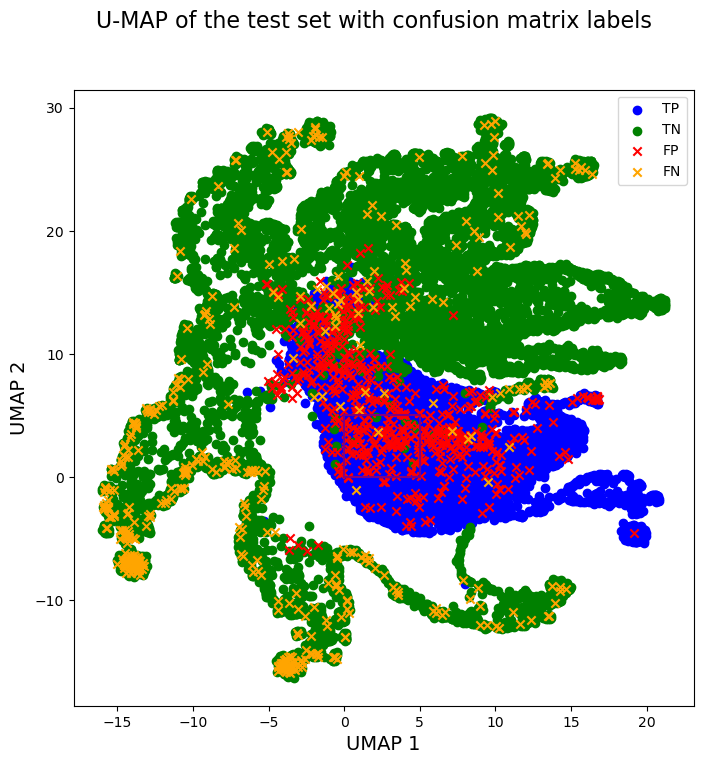

In [14]:
# Plot the U-MAP with the confusion matrix labels
fig, ax = plt.subplots(figsize=(8, 8))
fig.suptitle('U-MAP of the test set with confusion matrix labels', fontsize=16)

for i, cm_label in enumerate(['TP', 'TN', 'FP', 'FN']):
    cm_data = x_bins_test[x_bins_test['CM_Label'] == cm_label]
    ax.scatter(cm_data['UMAP_1'], cm_data['UMAP_2'], c=color_map.colors[i], marker=markers[i], label=cm_label)

ax.set_xlabel('UMAP 1', fontsize=14)
ax.set_ylabel('UMAP 2', fontsize=14)
ax.legend()


# plot a square box around the cluster of interest
## IMPORTANT, LOWER BOUND FIRST THEN UPPER BOUND
cluster_x = [0, 5] # U-Map 1 bounds
cluster_y = [0, 5] # U-Map 2 bounds 
box_color = 'purple'
ax.plot([cluster_x[0], cluster_x[0]], [cluster_y[0], cluster_y[1]], c=box_color)
ax.plot([cluster_x[1], cluster_x[1]], [cluster_y[0], cluster_y[1]], c=box_color)
ax.plot([cluster_x[0], cluster_x[1]], [cluster_y[0], cluster_y[0]], c=box_color)
ax.plot([cluster_x[0], cluster_x[1]], [cluster_y[1], cluster_y[1]], c=box_color)
plt.show()


In [31]:
def visualize_shap_values(sample_id,title):

    sample_raw = x_raw_test[x_raw_test['Sample_id'] == sample_id]
    sample_bin = x_bins_test_reset[x_bins_test_reset['Sample_id'] == sample_id].index
    # print(sample_bin)
    # print("Sample bin index",x_bins_test_reset[x_bins_test_reset['Sample_id'] == sample_id])
    
    shap_values = explainer.shap_values(x_bins_test_scaled[sample_bin][0], nsamples=40)
    raw_value=x_bins_test[x_bins_test['Sample_id'] == sample_id]
    #select only bin columns
    raw_value=raw_value[bin_column_names]
    
    #convert the row values to array
    raw_value=raw_value.values[0]
    
    # print(raw_value)
    ##plot both the values side by side
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))
    #plot the FP feature values in horizontal bar chart
    axs[0].barh(bin_column_names,raw_value) #x_bins_test_scaled[index]
    axs[0].set_xlabel('Feature Value')
    axs[0].set_ylabel('Feature Name')
    axs[0].set_title('Feature Values'+title)
    #plot the FP feature values in horizontal bar chart
    axs[1].barh(bin_column_names, shap_values)
    axs[1].set_xlabel('Feature Value')
    axs[1].set_ylabel('Feature Name')
    axs[1].set_title('Shape values'+title)
    plt.show()

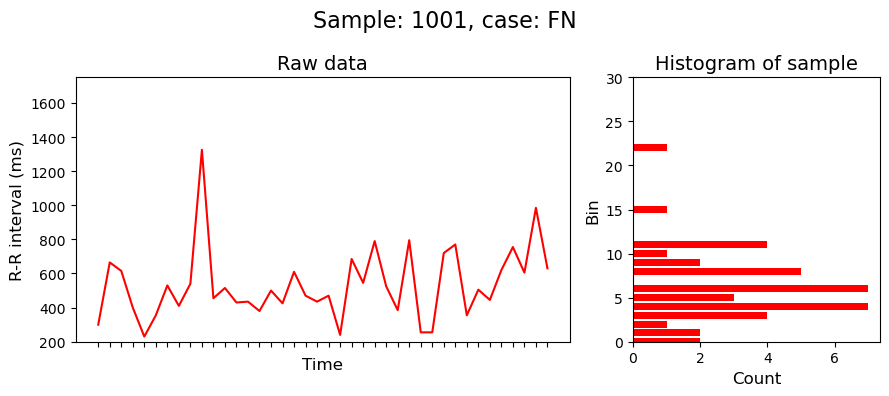

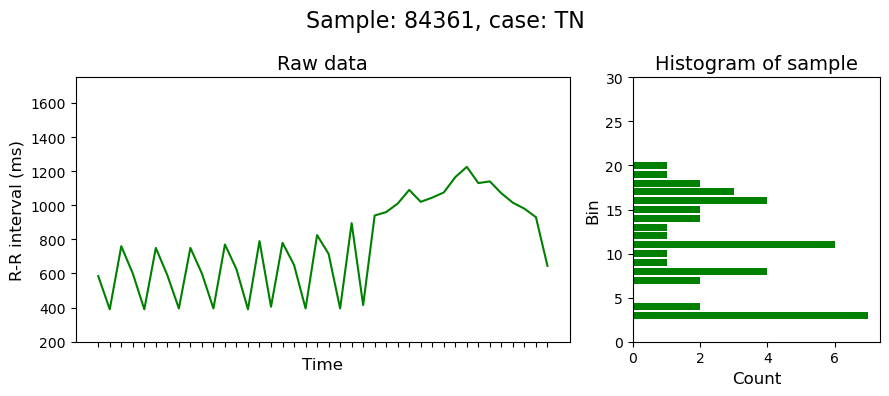

1001
Index([3551], dtype='int64')
Sample bin index       bin_1  bin_2  bin_3  bin_4  bin_5  bin_6  bin_7  bin_8  bin_9  bin_10  \
3551      2      2      1      4      7      3      7      0      5       2   

      ...  bin_28  bin_29  bin_30  bin_31  Sample_id  Prediction  Class_Label  \
3551  ...       0       0       0       0       1001         0.0          1.0   

      CM_Label   UMAP_1    UMAP_2  
3551        FN  2.25542  3.685839  

[1 rows x 37 columns]


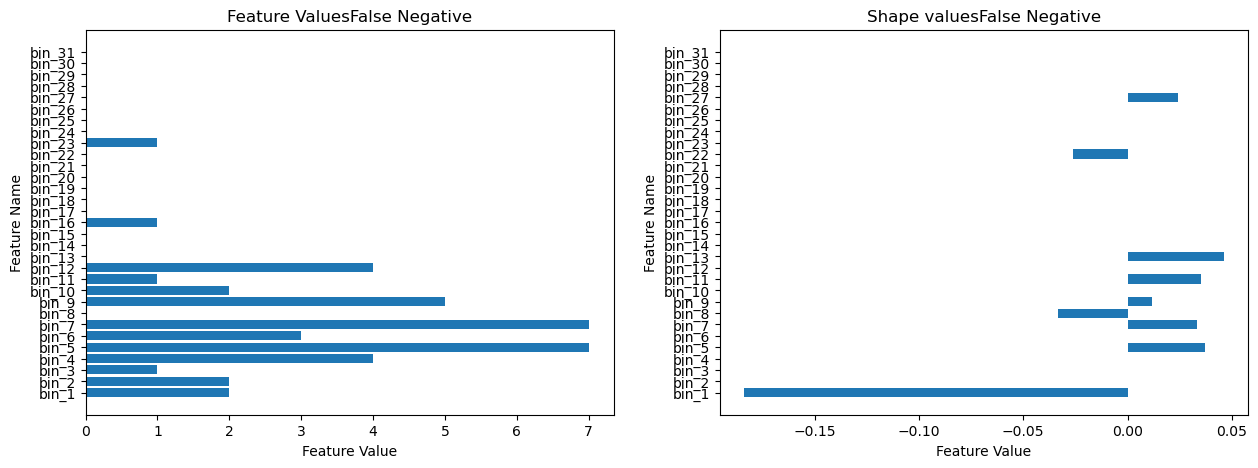

Index([2375], dtype='int64')
Sample bin index       bin_1  bin_2  bin_3  bin_4  bin_5  bin_6  bin_7  bin_8  bin_9  bin_10  \
2375      0      0      0      7      2      0      0      2      4       1   

      ...  bin_28  bin_29  bin_30  bin_31  Sample_id  Prediction  Class_Label  \
2375  ...       0       0       0       0      84361         0.0          0.0   

      CM_Label    UMAP_1    UMAP_2  
2375        TN  3.987086  2.316464  

[1 rows x 37 columns]


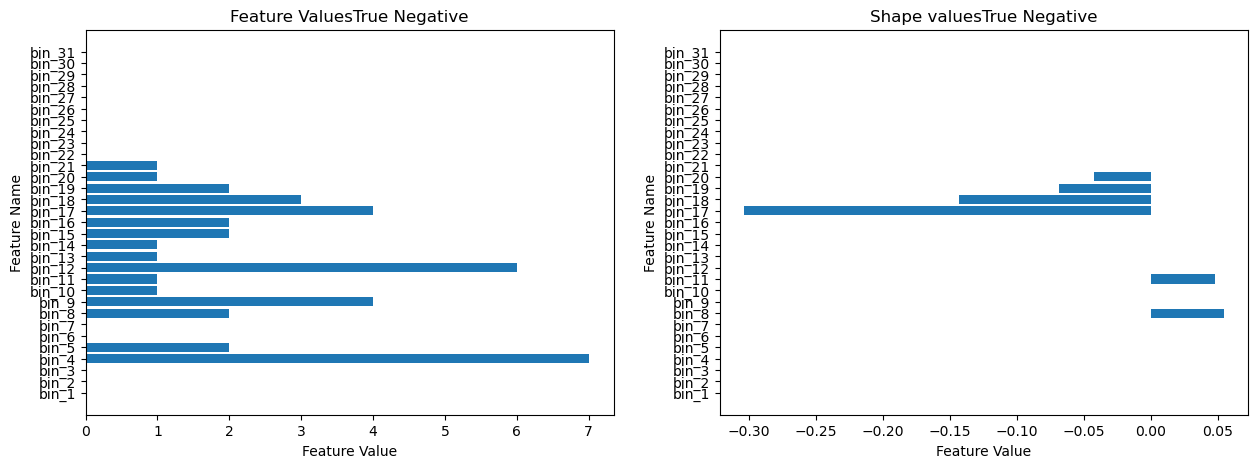

In [32]:
# From inside the cluster box (in the test data plot), sample the following CM_labels
cluster_samples = x_bins_test[(x_bins_test['UMAP_1'] > cluster_x[0]) & (x_bins_test['UMAP_1'] < cluster_x[1]) & (x_bins_test['UMAP_2'] > cluster_y[0]) & (x_bins_test['UMAP_2'] < cluster_y[1])]
cluster_samples['CM_Label'].value_counts() #interesting to see the distribution of the CM labels

#color_map = mcolors.ListedColormap(['blue', 'green', 'red', 'orange']) # TP, TN, FP, FN

#sample each case from the cluster
fn_sample_id = cluster_samples[cluster_samples['CM_Label'] == 'FN'].sample(1)['Sample_id'].values[0]
tn_sample_id = cluster_samples[cluster_samples['CM_Label'] == 'TN'].sample(1)['Sample_id'].values[0]
#tp_sample_id = cluster_samples[cluster_samples['CM_Label'] == 'TP'].sample(1)['Sample_id'].values[0]
#fp_sample_id = cluster_samples[cluster_samples['CM_Label'] == 'FP'].sample(1)['Sample_id'].values[0]

plot_sample(fn_sample_id, color_case = 'red')
plot_sample(tn_sample_id, color_case = 'green')
#plot_sample(tp_sample_id, color_case = 'blue')
#plot_sample(fp_sample_id, color_case = 'orange')

print(fn_sample_id)
visualize_shap_values(fn_sample_id,'False Negative')
visualize_shap_values(tn_sample_id,'True Negative')


In [27]:
#how to get index using sample id
x_bins_test.columns

Index(['bin_1', 'bin_2', 'bin_3', 'bin_4', 'bin_5', 'bin_6', 'bin_7', 'bin_8',
       'bin_9', 'bin_10', 'bin_11', 'bin_12', 'bin_13', 'bin_14', 'bin_15',
       'bin_16', 'bin_17', 'bin_18', 'bin_19', 'bin_20', 'bin_21', 'bin_22',
       'bin_23', 'bin_24', 'bin_25', 'bin_26', 'bin_27', 'bin_28', 'bin_29',
       'bin_30', 'bin_31', 'Sample_id', 'Prediction', 'Class_Label',
       'CM_Label', 'UMAP_1', 'UMAP_2'],
      dtype='object')

In [17]:
x_bins_test_scaled
#reset inndex of X_bins_test
x_bins_test_reset = x_bins_test.reset_index(drop=True)

In [18]:
x_bins_test_reset

,bin_1,bin_2,bin_3,bin_4,bin_5,bin_6,bin_7,bin_8,bin_9,bin_10,...,bin_28,bin_29,bin_30,bin_31,Sample_id,Prediction,Class_Label,CM_Label,UMAP_1,UMAP_2
0,0,0,6,12,10,5,4,1,2,0,...,0,0,0,0,19796,1.0,1.0,TP,8.067944,0.139064
1,0,0,0,37,3,0,0,0,0,0,...,0,0,0,0,50619,1.0,1.0,TP,18.505140,0.185045
2,0,0,0,0,0,0,0,16,24,0,...,0,0,0,0,103456,0.0,0.0,TN,-5.733210,0.716939
3,0,0,0,1,1,0,0,2,34,0,...,0,0,0,0,96618,0.0,0.0,TN,-12.965647,-0.929589
4,0,0,1,0,2,32,5,0,0,0,...,0,0,0,0,47657,0.0,1.0,FN,9.766925,6.494465
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21850,0,0,0,0,0,0,1,37,0,0,...,0,0,0,0,106610,0.0,0.0,TN,-1.217852,-12.852146
21851,0,0,0,2,10,9,8,3,2,3,...,0,0,0,0,2313,1.0,1.0,TP,2.034624,4.894468
21852,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,86398,0.0,0.0,TN,13.044961,24.432613
21853,0,0,0,0,0,0,0,19,20,0,...,0,0,0,0,68584,0.0,0.0,TN,-5.558876,-1.574319
